In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import json
from facenet_pytorch import MTCNN
from PIL import Image
from matplotlib.patches import Rectangle
import numpy as np

/home/nele_pauline_suffo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load json
json_path = '../outputs/combined_detections_yolo.json'
with open(json_path, 'r') as f:
    face_detections = json.load(f)
    
annotations = face_detections['annotations']
images = face_detections['images']
videos = face_detections['videos']

In [8]:
[image for image in images if image['id'] == 3][0]['file_name']

'quantex_at_home_id262565_2022_05_08_01_000000.jpg'

In [5]:
def get_bbox(annotations, images, image_id):
    # Find the image entry that matches the provided image_id (file_name)
    for image in images:
        if image["file_name"] == image_id:
            # Extract the matching image id
            matching_image_id = image["id"]
            
            # Find all annotations where annotation["image_id"] matches matching_image_id
            bboxes = [annotation["bbox"] for annotation in annotations if annotation["image_id"] == matching_image_id]
            
            return bboxes  # Return the list of bounding boxes
    
    return None  # Return None if no matching image or annotations found


def draw_detections(image_path, boxes):
    """
    Draw bounding boxes and facial landmarks on an image.

    :param image_path: Path to the image file.
    :param detections: A list of dictionaries containing 'box' and 'keypoints' for each detection.
    """
    # Load image using OpenCV
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    
    view_frames = [image_rgb] * len(boxes)  # Assuming you have a single image
 
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # Adjust this if you have multiple images
    
    ax.imshow(view_frames[0])
    ax.axis('off')
    
    for box in boxes:
        # Convert box to integer
        box = [int(x) for x in box]
        width = box[2] - box[0]  # x2 - x1
        height = box[3] - box[1]  # y2 - y1
        # Create a rectangle patch for the bounding box
        rect = Rectangle((box[0], box[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')
        
        # Add the rectangle patch to the plot
        ax.add_patch(rect)

    plt.show()


Bounding box(es): [707.7857055664062, 90.08586883544922, 455.83941650390625, 445.9886474609375]
Bounding box(es): [1443.167724609375, 1.8496307134628296, 859.625732421875, 862.9310302734375]
Bounding box(es): [1396.7523193359375, 182.36656188964844, 127.4501953125, 180.0847930908203]
Bounding box(es): [437.5933532714844, 258.20440673828125, 1858.6883544921875, 1018.7693481445312]
Bounding box(es): [461.10430908203125, 996.7354736328125, 597.3120727539062, 292.7183837890625]
Bounding box(es): [928.7022094726562, 213.62782287597656, 109.71917724609375, 99.14698791503906]
Bounding box(es): [1970.490234375, 162.12242126464844, 95.25146484375, 196.78184509277344]
Bounding box(es): [1457.8157958984375, 2.1590607166290283, 346.7606201171875, 306.2537536621094]
Bounding box(es): [1351.4185791015625, 18.858745574951172, 133.8670654296875, 310.000732421875]


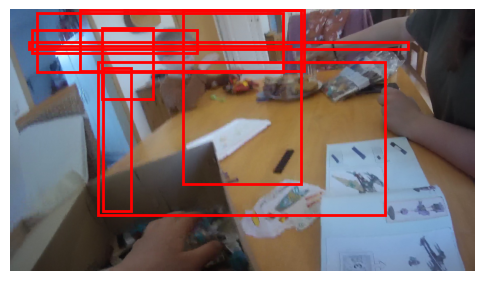

In [6]:
image_name = 'quantex_at_home_id255706_2018_12_21_01_031860.jpg'
image_path = f'../../../ProcessedData/images/{image_name}'
bboxes = get_bbox(annotations, images,image_name)
bboxes
if len(bboxes) == 0:
    print(f"No bounding boxes found for image {image_name}")
     # Open the image file
    image = Image.open(image_path)
    display(image)
else:
    for bbox in bboxes:
        print(f'Bounding box(es): {bbox}')
    draw_mtcnn_detections(image_path, bboxes)

## Create MTCNN model

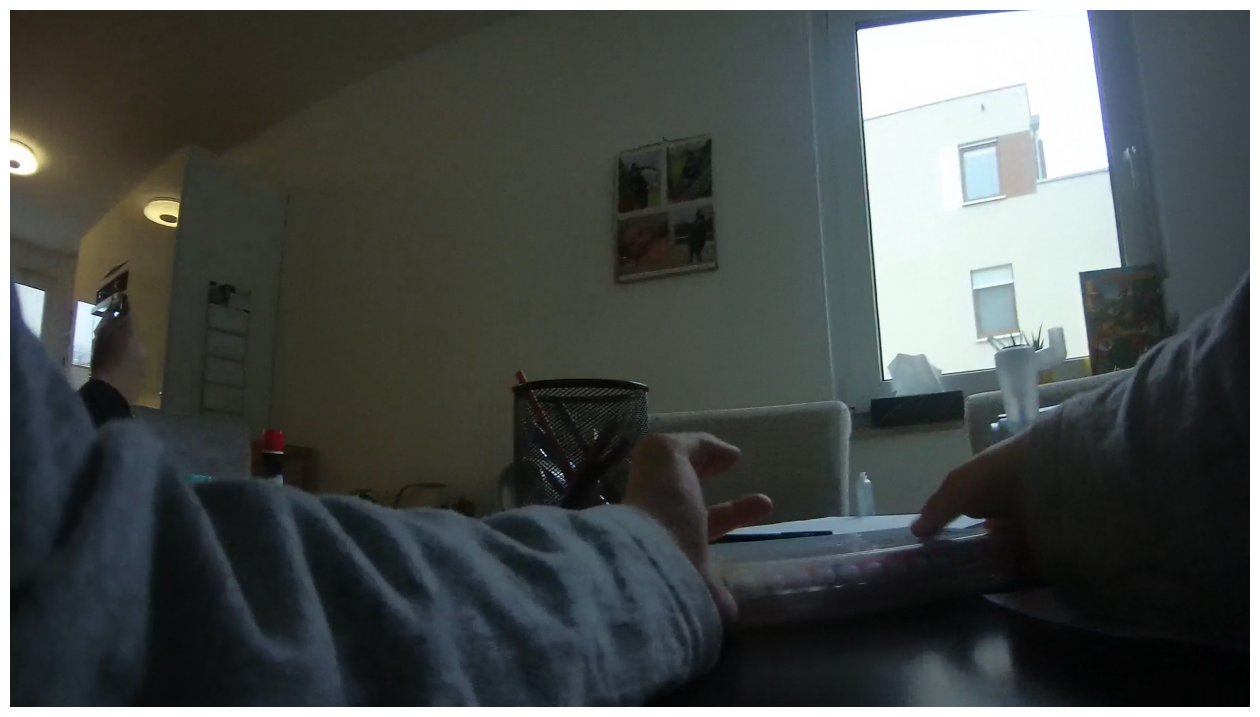

In [212]:
image_name = 'quantex_at_home_id261609_2022_04_01_02_049500.jpg'
image_path = f'../../../ProcessedData/images/{image_name}'
# Create face detector
mtcnn = MTCNN(keep_all=True, device='cuda')

# Load the image using OpenCV
frame = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# Convert the NumPy array to a PIL Image
frame = Image.fromarray(frame)

# Detect face
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)
if landmarks:
    for landmark in landmarks:
        left_eye = landmark[0]
        right_eye = landmark[1]
        nose = landmark[2]
        left_mouth_corner = landmark[3] 
        right_mouth_corner = landmark[4]

    # Visualize#
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(frame)
ax.axis('off')
if boxes is not None:
    for box, landmark in zip(boxes, landmarks):
        print(box)
        # Draw the bounding box
        width = box[2] - box[0]  # x2 - x1
        height = box[3] - box[1]  # y2 - y1

        # Create a Rectangle patch
        rect = Rectangle((box[0], box[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle to the plot
        ax.add_patch(rect)
        # ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
        ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()

## Estimate headpose

In [1]:
import numpy as np

def get_eye_center(eye_left, eye_right):
    return (eye_left + eye_right) / 2.0

def estimate_gaze_direction(eye_center, nose):
    return nose - eye_center

def is_looking_at_camera(eye_center, nose, camera_position):
    gaze_direction = estimate_gaze_direction(eye_center, nose)
    camera_direction = camera_position - eye_center
    gaze_angle = np.arccos(np.dot(gaze_direction, camera_direction) /
                           (np.linalg.norm(gaze_direction) * np.linalg.norm(camera_direction)))
    return gaze_angle < np.pi / 8  # 22.5 degrees threshold

In [ ]:
# Example landmarks
left_eye = np.array([x_left_eye, y_left_eye])
right_eye = np.array([x_right_eye, y_right_eye])
nose = np.array([x_nose, y_nose])
camera_position = np.array([image_width / 2, image_height / 2])

eye_center = get_eye_center(left_eye, right_eye)
if is_looking_at_camera(eye_center, nose, camera_position):
    print("The person is looking at the camera")
else:
    print("The person is not looking at the camera")

## Check Yolo Output

In [14]:
# load json
json_path = '../outputs/combined_detections.json'
with open(json_path, 'r') as f:
    person_detections = json.load(f)
    
annotations = person_detections['annotations']
images = person_detections['images']
videos = person_detections['videos']

In [15]:
annotations

[{'id': 1,
  'image_id': 1,
  'category_id': 0,
  'bbox': [0.5166046023368835, 0.5, 0.9667908549308777, 1.0],
  'score': 0.32214513421058655},
 {'id': 3,
  'image_id': 8,
  'category_id': 0,
  'bbox': [0.2710786461830139,
   0.9760429263114929,
   0.09636219590902328,
   0.04791410639882088],
  'score': 0.5894771814346313},
 {'id': 5,
  'image_id': 16,
  'category_id': 0,
  'bbox': [0.1267968714237213,
   0.9695176482200623,
   0.08255021274089813,
   0.060603201389312744],
  'score': 0.6080732941627502},
 {'id': 6,
  'image_id': 17,
  'category_id': 0,
  'bbox': [0.17590001225471497,
   0.9715741872787476,
   0.09036055207252502,
   0.05636493116617203],
  'score': 0.5280061960220337},
 {'id': 2,
  'image_id': 2,
  'category_id': 0,
  'bbox': [0.5166046023368835, 0.5, 0.9667908549308777, 1.0],
  'score': 0.32214513421058655},
 {'id': 4,
  'image_id': 11,
  'category_id': 0,
  'bbox': [0.2710786461830139,
   0.9760429263114929,
   0.09636219590902328,
   0.04791410639882088],
  'score'

In [10]:
images

[{'id': 1,
  'video_id': 0,
  'frame_id': 0,
  'file_name': 'quantex_at_home_id258239_2020_08_23_01_000000.jpg'},
 {'id': 3,
  'video_id': 0,
  'frame_id': 30,
  'file_name': 'quantex_at_home_id258239_2020_08_23_01_000030.jpg'},
 {'id': 4,
  'video_id': 0,
  'frame_id': 60,
  'file_name': 'quantex_at_home_id258239_2020_08_23_01_000060.jpg'},
 {'id': 6,
  'video_id': 0,
  'frame_id': 90,
  'file_name': 'quantex_at_home_id258239_2020_08_23_01_000090.jpg'},
 {'id': 8,
  'video_id': 0,
  'frame_id': 120,
  'file_name': 'quantex_at_home_id258239_2020_08_23_01_000120.jpg'},
 {'id': 9,
  'video_id': 0,
  'frame_id': 150,
  'file_name': 'quantex_at_home_id258239_2020_08_23_01_000150.jpg'},
 {'id': 11,
  'video_id': 0,
  'frame_id': 180,
  'file_name': 'quantex_at_home_id258239_2020_08_23_01_000180.jpg'},
 {'id': 13,
  'video_id': 0,
  'frame_id': 210,
  'file_name': 'quantex_at_home_id258239_2020_08_23_01_000210.jpg'},
 {'id': 14,
  'video_id': 0,
  'frame_id': 240,
  'file_name': 'quantex_at_

In [20]:
[image for image in images if image['id'] == 3][0]['file_name']

'quantex_at_home_id258239_2020_08_23_01_000030.jpg'

In [23]:
def get_bbox(annotations, file_name):
    # Find the image entry that matches the provided image_id (file_name)
    for image in images:
        if image["file_name"] == file_name:
            # Extract the matching image id
            matching_image_id = image["id"]
            
            # Find all annotations where annotation["image_id"] matches matching_image_id
            bboxes = [annotation["bbox"] for annotation in annotations if annotation["image_id"] == matching_image_id]
            
            return bboxes  # Return the list of bounding boxes
    
    return None  # Return None if no matching image or annotations found

In [24]:
import cv2
from PIL import Image
import numpy as np

# Example function to convert normalized coordinates to pixel coordinates
def normalized_to_pixel(x_center, y_center, width, height, image_width, image_height):
    x_center_pixel = x_center * image_width
    y_center_pixel = y_center * image_height
    width_pixel = width * image_width
    height_pixel = height * image_height

    x_min = int(x_center_pixel - (width_pixel / 2))
    y_min = int(y_center_pixel - (height_pixel / 2))
    x_max = int(x_center_pixel + (width_pixel / 2))
    y_max = int(y_center_pixel + (height_pixel / 2))

    return x_min, y_min, x_max, y_max

# Given image name
image_name = 'quantex_at_home_id255706_2018_12_21_01_024750.jpg'

# Extract video name from image_name
parts = image_name.split('_')
video_name = '_'.join(parts[:8])  # "quantex_at_home_id258239_2020_08_23_01"
video_path = f'../../../ProcessedData/videos/{video_name}.MP4'  # Path to the corresponding video file

# Extract frame number from image_name
frame_number_str = image_name.split('_')[-1].split('.')[0]  # "000270"
frame_number = int(frame_number_str) // 30  # 270 / 30 = 9

# Step 2: Get bounding boxes for the image
bboxes = get_bbox(annotations, image_name)  # Assuming this function is defined

# Step 3: Open video and read specific frame using OpenCV
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error opening video file {video_path}")
else:
    # Set the video to the desired frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()
    if not ret:
        print(f"Failed to read frame {frame_number} from {video_path}")
    else:
        # Convert the frame to RGB (OpenCV uses BGR by default)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert the frame to a PIL image (optional)
        image = Image.fromarray(frame_rgb)

        # Get image dimensions
        image_height, image_width, _ = frame.shape

        if bboxes is None or len(bboxes) == 0:
            print(f"No bounding boxes found for image {image_name}")
        else:
            # Draw bounding boxes on the frame
            for bbox in bboxes:
                print(f'Bounding box: {bbox}')
                x_center, y_center, width, height = bbox  # Unpack the bounding box coordinates

                # Convert normalized coordinates to pixel coordinates
                x_min, y_min, x_max, y_max = normalized_to_pixel(x_center, y_center, width, height, image_width, image_height)

                # Draw the bounding box
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green box with 2px thickness

                # Optionally, draw a label with confidence score or other information
                label = 'Person'  # Replace with actual label if available
                cv2.putText(frame, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

            # Convert frame with drawn bounding boxes back to RGB for PIL (if needed)
            frame_rgb_with_bboxes = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image_with_bboxes = Image.fromarray(frame_rgb_with_bboxes)

            # Save the image with bounding boxes to a file instead of displaying
            output_path = f'output_{image_name}'
            image_with_bboxes.save(output_path)
            print(f"Saved image with bounding boxes to {output_path}")

    # Release the video capture object
    cap.release()


Bounding box: [0.7287418842315674, 0.38077104091644287, 0.1946006864309311, 0.5833992958068848]
Saved image with bounding boxes to output_quantex_at_home_id255706_2018_12_21_01_024750.jpg



0: 384x640 2 persons, 22.9ms
Speed: 2.2ms preprocess, 22.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
person: 0.91
person: 0.56


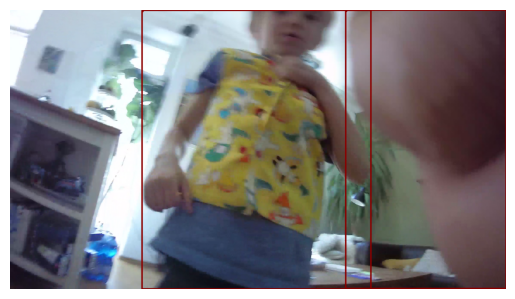

In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import display, clear_output

# Load YOLOv8 model
def load_model(weights_path):
    model = YOLO(weights_path)
    return model

# Process and display a single frame
def process_and_display_frame(frame, model):
    # Convert frame to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Run the model
    results = model(rgb_frame)
    # Access the 'boxes' object from 'results'
    boxes = results[0].boxes
    
    if boxes is None or boxes.xywhn is None:
        print("No bounding boxes detected.")
        plt.imshow(rgb_frame)
        plt.axis('off')
        plt.show()
        return
    
    # Get frame dimensions
    frame_height, frame_width = frame.shape[:2]
    
    # Extract bounding boxes, confidence, and class indices
    bbox_np = boxes.xywhn.cpu().numpy()  # Normalized x_center, y_center, width, height
    confidences = boxes.conf.cpu().numpy()  # Confidence scores
    classes = boxes.cls.cpu().numpy().astype(int)  # Class indices

    # Process each bounding box
    for i, (x_center, y_center, width, height) in enumerate(bbox_np):
        # Convert normalized coordinates to pixel values
        x1 = int((x_center - width / 2) * frame_width)
        y1 = int((y_center - height / 2) * frame_height)
        x2 = int((x_center + width / 2) * frame_width)
        y2 = int((y_center + height / 2) * frame_height)
        
        # Draw bounding boxes on the frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 139), 5)
        
        # Get confidence and class from results
        conf = confidences[i]
        cls = classes[i]
        label = f"{model.names[cls]}: {conf:.2f}"
        print(label)
        cv2.putText(frame, label, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 139), 5)
        
    # Convert frame back to RGB for display
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_frame)
    plt.axis('off')
    plt.show()

# Extract a specific frame from a video
def get_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Frame number {frame_number} could not be retrieved.")
    return frame

# Main execution
frame_number = 1990  # Specify the frame number you want to process
video_path = '../../../ProcessedData/videos/quantex_at_home_id255237_2022_05_26_01.MP4'  # Update with your video path
weights_path = '../../../models/yolov8_trained.pt'  # Update with your model path

# Load the model
model = load_model(weights_path)

# Get the specified frame
frame = get_frame(video_path, frame_number)

# Process and display the frame
process_and_display_frame(frame, model)


In [12]:
import cv2
import json

def draw_bounding_boxes(frame, bbox_pixel, bbox_normalized, img_width, img_height):
    """
    Draws both pixel-based and normalized bounding boxes on the frame.
    
    Parameters
    ----------
    frame : np.array
        The image frame from the video.
    bbox_pixel : list
        Bounding box coordinates in pixel format [x1, y1, x2, y2].
    bbox_normalized : list
        Bounding box coordinates in normalized format [x_center, y_center, width, height].
    img_width : int
        Width of the image.
    img_height : int
        Height of the image.
    """
    
    # Draw pixel-based bounding box
    x1, y1, x2, y2 = bbox_pixel
    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    
    # Convert normalized bbox to pixel coordinates
    x_center, y_center, width, height = bbox_normalized
    x1_norm = int((x_center - width / 2) * img_width)
    y1_norm = int((y_center - height / 2) * img_height)
    x2_norm = int((x_center + width / 2) * img_width)
    y2_norm = int((y_center + height / 2) * img_height)
    
    # Draw normalized bounding box
    cv2.rectangle(frame, (x1_norm, y1_norm), (x2_norm, y2_norm), (0, 255, 0), 2)
    
    # Display the image
    cv2.imshow('Bounding Boxes', frame)
    cv2.waitKey(0)  # Wait for a key press to close the window
    cv2.destroyAllWindows()


In [ ]:

# Example usage:
# Assume frame is obtained from the video, and you have bounding boxes in both formats.
frame = cv2.imread('path_to_image')
bbox_pixel = [50, 50, 150, 150]  # Example pixel-based bounding box
bbox_normalized = [0.5, 0.5, 0.2, 0.2]  # Example normalized bounding box (normalized values)
img_width = frame.shape[1]
img_height = frame.shape[0]

draw_bounding_boxes(frame, bbox_pixel, bbox_normalized, img_width, img_height)

In [6]:
def draw_yolo_bounding_box(img, x_center, y_center, width, height):
    """
    Draws a bounding box on the image using YOLO format coordinates.

    Parameters:
    - img: The image on which to draw the bounding box.
    - x_center, y_center, width, height: YOLO format coordinates (normalized).

    Returns:
    - img: The image with the bounding box drawn.
    """
    img_height, img_width = img.shape[:2]
    
    # Convert normalized coordinates to absolute coordinates
    x_center_abs = float(x_center) * img_width
    y_center_abs = float(y_center) * img_height
    width_abs = float(width) * img_width
    height_abs = float(height) * img_height
    
    # Calculate top-left and bottom-right coordinates
    x1 = int(x_center_abs - width_abs / 2)
    y1 = int(y_center_abs - height_abs / 2)
    x2 = int(x_center_abs + width_abs / 2)
    y2 = int(y_center_abs + height_abs / 2)
    print(x1, y1, x2, y2)
    
    # Draw the bounding box on the image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    return img


def load_yolo_annotations(annotation_path) -> list:
    """
    Loads YOLO annotations from a text file.

    Parameters:
    - annotation_path: Path to the annotation file.

    Returns:
    - annotations: List of YOLO annotations.
    """
    annotations = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id, x_center, y_center, width, height = parts
                annotations.append((class_id, x_center, y_center, width, height))
    return annotations

536 402 896 1296


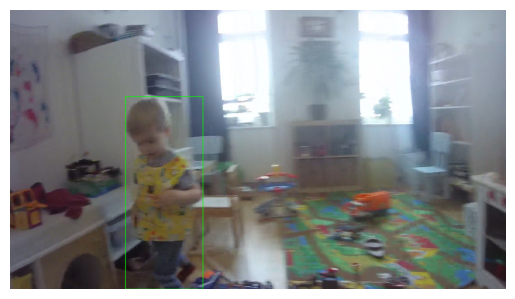

In [7]:
# Paths to the image and annotation file
frame = 'quantex_at_home_id255237_2022_05_08_03_004530'
image_path_01 = f'../../../ProcessedData/yolo/images/train/{frame}.jpg'  
image_path_02 = f'../../../ProcessedData/yolo/images/val/{frame}.jpg'  
annotation_path_1 = f'../../../ProcessedData/yolo/labels/train/{frame}.txt'  
annotation_path_2 = f'../../../ProcessedData/yolo/labels/val/{frame}.txt'  

if os.path.exists(annotation_path_1):
    annotation_path = annotation_path_1
elif os.path.exists(annotation_path_2):
    annotation_path = annotation_path_2
else:
    raise FileNotFoundError(f"Annotation file not found in either directory for frame: {frame}")

if os.path.exists(image_path_01):
    image_path = image_path_01
elif os.path.exists(image_path_02):
    image_path = image_path_02
else:
    raise FileNotFoundError(f"Image file not found in either directory for frame: {frame}")
# Load the image
img = cv2.imread(image_path)
annotations = load_yolo_annotations(annotation_path)

# Draw bounding boxes for all annotations
for annotation in annotations:
    class_id, x_center, y_center, width, height = annotation
    img = draw_yolo_bounding_box(img, x_center, y_center, width, height)

# Convert BGR image to RGB for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()


In [5]:
import os
import random
import shutil
from pathlib import Path

def copy_subset(src_img_dir, src_label_dir, dst_img_dir, dst_label_dir, percentage=0.1):
    # Get list of image files
    img_files = list(Path(src_img_dir).glob('*.jpg'))
    total_files = len(img_files)
    subset_size = int(total_files * percentage)
    
    # Select a random subset of image files
    selected_images = random.sample(img_files, subset_size)
    
    # Create destination directories if they don't exist
    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_label_dir, exist_ok=True)

    for img_file in selected_images:
        # Copy image file
        shutil.copy(img_file, dst_img_dir)
        
        # Find corresponding label file
        label_file = src_label_dir / (img_file.stem + '.txt')  # Assuming labels are .txt files
        
        # Copy label file if it exists
        if label_file.exists():
            shutil.copy(label_file, dst_label_dir)


In [6]:
# Define paths
base_dir = Path('../../../ProcessedData/yolo')  # Change to your base directory
new_base_dir = Path('../../../ProcessedData/yolo_small')  # Change to your destination directory

# Define source and destination directories
src_train_img_dir = base_dir / 'images/train'
src_train_label_dir = base_dir / 'labels/train'
dst_train_img_dir = new_base_dir / 'images/train'
dst_train_label_dir = new_base_dir / 'labels/train'

src_val_img_dir = base_dir / 'images/val'
src_val_label_dir = base_dir / 'labels/val'
dst_val_img_dir = new_base_dir / 'images/val'
dst_val_label_dir = new_base_dir / 'labels/val'

# Copy subset of data (10% in this case)
copy_subset(src_train_img_dir, src_train_label_dir, dst_train_img_dir, dst_train_label_dir, percentage=0.1)
copy_subset(src_val_img_dir, src_val_label_dir, dst_val_img_dir, dst_val_label_dir, percentage=0.1)
